<a href="https://colab.research.google.com/github/PiyushTewari2/AUV_Navigation/blob/main/quantization_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install utils

In [3]:
import os
import torch
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp drive/MyDrive/squeezenet_fix.py .

In [6]:
import squeezenet_fix

In [5]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [7]:
!unzip '/content/drive/MyDrive/squeeze-net/Data.zip'

Archive:  /content/drive/MyDrive/squeeze-net/Data.zip
   creating: Data/
   creating: Data/Test_Data/
   creating: Data/Test_Data/Fire/
  inflating: Data/Test_Data/Fire/F_0.jpg  
  inflating: Data/Test_Data/Fire/F_1.jpg  
  inflating: Data/Test_Data/Fire/F_10.jpg  
  inflating: Data/Test_Data/Fire/F_11.jpg  
  inflating: Data/Test_Data/Fire/F_12.jpg  
  inflating: Data/Test_Data/Fire/F_13.jpg  
  inflating: Data/Test_Data/Fire/F_14.jpg  
  inflating: Data/Test_Data/Fire/F_15.jpg  
  inflating: Data/Test_Data/Fire/F_16.jpg  
  inflating: Data/Test_Data/Fire/F_17.jpg  
  inflating: Data/Test_Data/Fire/F_18.jpg  
  inflating: Data/Test_Data/Fire/F_19.jpg  
  inflating: Data/Test_Data/Fire/F_2.jpg  
  inflating: Data/Test_Data/Fire/F_20.jpg  
  inflating: Data/Test_Data/Fire/F_21.jpg  
  inflating: Data/Test_Data/Fire/F_22.jpg  
  inflating: Data/Test_Data/Fire/F_23.jpg  
  inflating: Data/Test_Data/Fire/F_24.jpg  
  inflating: Data/Test_Data/Fire/F_3.jpg  
  inflating: Data/Test_Data/Fire

In [8]:
data_transforms = {
    'Train_Data': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test_Data': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# Define the data directory
data_dir = '/content/Data'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train_Data', 'Test_Data']}
#image_datasets

In [10]:
#creating datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['Train_Data', 'Test_Data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train_Data', 'Test_Data']}
print(dataset_sizes)

class_names = image_datasets['Train_Data'].classes
class_names

{'Train_Data': 4516, 'Test_Data': 50}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['Fire', 'Non_Fire']

In [12]:
import torch
from torch import nn
from torch.autograd import Variable
import math

def compute_integral_part(input, overflow_rate):
    """Calculates the scaling factor (sf) that better represents the input"""
    # transform 'input' into an array of the abs of each elements
    abs_value = input.abs().view(-1)
    # sort the modulus array in descending order
    sorted_value = abs_value.sort(dim=0, descending=True)[0]
    # find what index corresponds to the max possibe modulus value, considering the overflow_rate.
    # for '0' overflow_rate, the index will be the one of the maximum module of all modules, and
    # the biggest modulus (index 0) will be chosen
    split_idx = int(overflow_rate * len(sorted_value))
    # value at that index
    v = sorted_value[split_idx]
    #print('v is {}'.format(v))
    if isinstance(v, Variable):
        v = v.data.cpu().numpy()
    # get the minimum ammount of bits required to represent the value chosen and consider it the
    # scaling factor. The '1e-12' is there to determine the smallest precision (if 'v' is too small)
    sf = math.ceil(math.log2(v+1e-12))
    #print('sf is {}'.format(sf))
    return sf

def linear_quantize(input, sf, bits, return_type='float'):
    """Converts a float value from the real numbers domain to a float in the quantized domain"""
    assert bits >= 1, bits
    if bits == 1:
        return torch.sign(input) - 1
    #print('inside sf is {}'.format(sf))
    # calculate the minimum step, considering that the 'sf' bits will quantize in the interval [0,1].
    # this is equivalento to compute 1/(2^(sf)),  or 2^(-sf)
    delta = math.pow(2.0, -sf)
    bound = math.pow(2.0, bits-1)
    # calculates min and maximum. For 8 bits, the quantized number will be between [-128,127].
    min_val = - bound
    max_val = bound - 1

    # dividing the input by delta and flooring
    ## rounded = torch.floor(input / delta + 0.5) # Equivalent to torch.round(input / delta)
    rounded = torch.round(input / delta)

    # calculate the output format base on the return type desired
    assert return_type in ['float', 'int'], 'Return type should be \'float\' or \'int\'!'
    if return_type == 'float':
        clipped_value = torch.clamp(rounded, min_val, max_val) * delta
    elif return_type == 'int':
        clipped_value = torch.clamp(rounded, min_val, max_val)
    else:
        # format not supported, returning float
        clipped_value = torch.clamp(rounded, min_val, max_val) * delta

    return clipped_value


class LinearQuant(nn.Module):
    def __init__(self, name, bits, sf=None, overflow_rate=0.0, counter=10):
        super(LinearQuant, self).__init__()
        self.name = name
        self._counter = counter

        self.bits = bits
        self.sf = sf
        self.overflow_rate = overflow_rate

    @property
    def counter(self):
        return self._counter

    def forward(self, input):
        if self._counter > 0:
            self._counter -= 1
            sf_new = self.bits - 1 - compute_integral_part(input, self.overflow_rate)
            self.sf = min(self.sf, sf_new) if self.sf is not None else sf_new
            return input
        else:
            output = linear_quantize(input, self.sf, self.bits)
            return output

    def __repr__(self):
        return '{}(sf={}, bits={}, overflow_rate={:.3f}, counter={})'.format(
self.__class__.__name__, self.sf, self.bits, self.overflow_rate, self.counter)


def duplicate_model_with_quant(model, bits, overflow_rate=0.0, counter=10):
    """assume that original model has at least a nn.Sequential"""

    import squeezenet_fix
    import torch
    import torch.nn as nn

    # Quantized Fire class
    class Fire_Quant(nn.Module):
        def __init__(self, inplanes, squeeze_planes,
                     expand1x1_planes, expand3x3_planes):
            super(Fire_Quant, self).__init__()
            self.inplanes = inplanes
            self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
            self.squeeze_quant = LinearQuant('squeeze_quant', bits=32)
            self.squeeze_activation = nn.ReLU(inplace=True)
            self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                       kernel_size=1)
            self.expand1x1_quant = LinearQuant('expand1x1_quant', bits=32)
            self.expand1x1_activation = nn.ReLU(inplace=True)
            self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                       kernel_size=3, padding=1)
            self.expand3x3_quant = LinearQuant('expand3x3_quant', bits=32)
            self.expand3x3_activation = nn.ReLU(inplace=True)
        def forward(self, x):
            x = self.squeeze_activation(self.squeeze_quant(self.squeeze(x)))
            return torch.cat([
                self.expand1x1_activation(self.expand1x1_quant(self.expand1x1(x))),
                self.expand3x3_activation(self.expand3x3_quant(self.expand3x3(x)))
            ], 1)



    if isinstance(model, nn.Sequential):
        l = OrderedDict()
        for k, v in model._modules.items():
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
                l[k] = v
                quant_layer = LinearQuant('{}_quant'.format(k), bits=bits, overflow_rate=overflow_rate, counter=counter)
                l['{}_{}_quant'.format(k, v.__class__.__name__)] = quant_layer
            else:
                l[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter)
        m = nn.Sequential(l)
        return m

    elif isinstance(model, squeezenet_fix.Fire):
        inplanes = model.inplanes
        squeeze_planes = model.squeeze.out_channels
        expand1x1_planes = model.expand1x1.out_channels
        expand3x3_planes = model.expand3x3.out_channels

        m = Fire_Quant(inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes)

        # copy layers (with weights) to the quantized layer
        m.squeeze = model.squeeze
        m.expand1x1 = model.expand1x1
        m.expand3x3 = model.expand3x3

        # adjust the LinearQuant layers
        m.squeeze_quant = LinearQuant('squeeze_quant', bits=bits, overflow_rate=overflow_rate, counter=counter)
        m.expand1x1_quant = LinearQuant('expand1x1_quant', bits=bits, overflow_rate=overflow_rate, counter=counter)
        m.expand3x3_quant = LinearQuant('expand3x3_quant', bits=bits, overflow_rate=overflow_rate, counter=counter)

        return m
    else:
        for k, v in model._modules.items():
            model._modules[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter)
    return model

def eval_model(squeezenet, criterion, verbose=False):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders['Test_Data'])
    if verbose:
        print("Evaluating model")
        print('-' * 10)

    squeezenet.train(False)
    squeezenet.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['Test_Data']):
            if verbose:
                if i % 10 == 0:
                    print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)


            inputs, labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels

            outputs = squeezenet(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.data
            acc_test += torch.sum(preds == labels.data).item()

            # del inputs, labels, outputs, preds
            # torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes['Test_Data']
    avg_acc = acc_test / dataset_sizes['Test_Data']

    elapsed_time = time.time() - since
    if verbose:
        print()
        print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print("Avg loss (test): {:.4f}".format(avg_loss))
        print("Avg acc (test): {:.4f}".format(avg_acc))
        print('-' * 10)
    return avg_acc, avg_loss

In [13]:
x = torch.ones(3, 3)
x[0,2] = 1
x[0,2] = 3.6
abs_values = x.abs().view(-1)
sorted_values = abs_values.sort(dim=0, descending=True)[0]
print(sorted_values)

overflow_rate = 0.0
split_idx = int(overflow_rate * len(sorted_values))
print(split_idx)

v = sorted_values[split_idx]
v = 5
print("v is {}".format(v))
a = math.log2(v+1e-12)
print(a)

sf = compute_integral_part(x, 0.0)
print(sf)

tensor([3.6000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
0
v is 5
2.321928094887651
2


In [14]:
bits = 8

x = torch.ones(1, 1)
x[0,0] = 25

sf = compute_integral_part(x, 0.0)
print('sf is {}'.format(sf))

sf = bits - 1. - sf
print('post-calculated sf is {}'.format(sf))

delta = math.pow(2.0, -sf)
print('delta is {}'.format(delta))

a = torch.Tensor(1)
a[0] = 32
quantized = torch.round(a / delta)
print('a ({}) quantized is {}'.format(a.numpy(), quantized.numpy()))
rounded = quantized*delta
print('a ({}) rounded is {}'.format(a.numpy(), rounded.numpy()))

sf is 5
post-calculated sf is 2.0
delta is 0.25
a ([32.]) quantized is [128.]
a ([32.]) rounded is [32.]


In [15]:
import argparse
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark =True
from collections import OrderedDict

import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn

#parser = argparse.ArgumentParser(description='PyTorch SVHN Example')
# parser.add_argument('--type', default='cifar10', help='|'.join(selector.known_models))
# parser.add_argument('--quant_method', default='linear', help='linear|minmax|log|tanh')
#parser.add_argument('--batch_size', type=int, default=100, help='input batch size for training (default: 64)')
#parser.add_argument('--gpu', default=None, help='index of gpus to use')
#parser.add_argument('--ngpu', type=int, default=8, help='number of gpus to use')
#parser.add_argument('--seed', type=int, default=117, help='random seed (default: 1)')
# parser.add_argument('--model_root', default='~/.torch/models/', help='folder to save the model')
# parser.add_argument('--data_root', default='/tmp/public_dataset/pytorch/', help='folder to save the model')
# parser.add_argument('--logdir', default='log/default', help='folder to save to the log')

#parser.add_argument('--input_size', type=int, default=224, help='input size of image')
# parser.add_argument('--n_sample', type=int, default=20, help='number of samples to infer the scaling factor')
#parser.add_argument('--param_bits', type=int, default=8, help='bit-width for parameters')
#parser.add_argument('--bn_bits', type=int, default=32, help='bit-width for running mean and std')
#parser.add_argument('--fwd_bits', type=int, default=8, help='bit-width for layer output')
# parser.add_argument('--overflow_rate', type=float, default=0.0, help='overflow rate')
# args = parser.parse_args()

args = {}

args['batch_size'] = 100
args['gpu'] = None
args['ngpu'] = 8
args['seed'] = 117
args['input_size'] = 224
#args['param_bits'] = 2
#args['bn_bits'] = 2
#args['fwd_bits'] = 2
args['overflow_rate'] = 0.0

#args.gpu = misc.auto_select_gpu(utility_bound=0, num_gpu=args.ngpu, selected_gpus=args.gpu)
#args.ngpu = len(args.gpu)
#misc.ensure_dir(args.logdir)
#args.model_root = misc.expand_user(args.model_root)
#args.data_root = misc.expand_user(args.data_root)
#args.input_size = 299 if 'inception' in args.type else args.input_size
#assert args.quant_method in ['linear', 'minmax', 'log', 'tanh']
#print("=================FLAGS==================")
#for k, v in args.__dict__.items():
#    print('{}: {}'.format(k, v))
#print("========================================")

#assert torch.cuda.is_available(), 'no cuda'
torch.manual_seed(args['seed'])
torch.cuda.manual_seed(args['seed'])

use_gpu = torch.cuda.is_available()
# use_gpu = False
if use_gpu:
    print("Using CUDA")

In [21]:
def create_model():
    # load model and dataset fetcher
    # model_raw, ds_fetcher, is_imagenet = selector.select(args.type, model_root=args.model_root)
    #squeezenet1_1 = models.squeezenet1_1()

    # importing fixed version of squeezenet class and functions
    import squeezenet_fix

    squeezenet1_1 = squeezenet_fix.squeezenet1_1()

    # Freeze training for all layers
    for param in squeezenet1_1.features.parameters():
        param.require_grad = False


    # Newly created modules have require_grad=True by default
    num_features = squeezenet1_1.classifier[1].in_channels
    features = list(squeezenet1_1.classifier.children())[:-3] # Remove last 3 layers

    features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))])
    features.extend([nn.Flatten()]) # Add
    features.extend([nn.Linear(num_features, len(class_names))]) # Add
    features.extend([nn.Softmax(dim=1)]) # Add
    squeezenet1_1.classifier = nn.Sequential(*features) # Replace the model classifier

    if use_gpu:
        squeezenet1_1.load_state_dict(torch.load('/content/drive/MyDrive/squeezenet_v4_final.pt'))
    else:
        squeezenet1_1.load_state_dict(torch.load('/content/drive/MyDrive/squeezenet_v4_final.pt', map_location='cpu'))
    #print(squeezenet1_1)
    return squeezenet1_1

In [18]:
def quantize_state_dict(state_dict, bn_bits, param_bits, return_type='float'):
    if param_bits < 32:
        state_dict_quant = OrderedDict()
        sf_dict = OrderedDict()
        for k, v in state_dict.items():
            if 'running' in k:
                if bn_bits >=32:
                    print("Ignoring {}".format(k))
                    state_dict_quant[k] = v
                    continue
                else:
                    bits = bn_bits
            else:
                bits = param_bits

    #        if args.quant_method == 'linear':
    #            sf = bits - 1. - quant.compute_integral_part(v, overflow_rate=args.overflow_rate)
    #            v_quant  = quant.linear_quantize(v, sf, bits=bits)
    #        elif args.quant_method == 'log':
    #            v_quant = quant.log_minmax_quantize(v, bits=bits)
    #        elif args.quant_method == 'minmax':
    #            v_quant = quant.min_max_quantize(v, bits=bits)
    #        else:
    #            v_quant = quant.tanh_quantize(v, bits=bits)

            # The sf will be used to do the quantization. Subtract 1 for dividind the range by 2
            # (2^(-sf) will be calculated after), so half of the quatized range represents positive
            # numbers and the other half negative numbers. Subtract the ammount of bits required to
            # represent the max abs value of the input to adjust the scale. At the end of the day,
            # the operation done through these steps is equivalent to consider that you have "bits - 1"
            # bits to quantize the maximum modulus of the input array. I don't know why to make such simple
            # operation not explicit...
            sf = bits - 1. - compute_integral_part(v, overflow_rate=args['overflow_rate'])
            #sf = compute_integral_part(v, overflow_rate=args['overflow_rate'])
            v_quant  = linear_quantize(v, sf, bits=bits, return_type=return_type)
            state_dict_quant[k] = v_quant
        return state_dict_quant

In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time


def quantize_model_forward_activation(model, fwd_bits):
    # Quantize the forward activaton of parameters on the model
    if fwd_bits < 32:
        model = duplicate_model_with_quant(model, bits=fwd_bits)
        #print(squeezenet1_1)
        #val_ds_tmp = ds_fetcher(10, data_root=args.data_root, train=False, input_size=args.input_size)
        #misc.eval_model(model_raw, val_ds_tmp, ngpu=1, n_sample=args.n_sample, is_imagenet=is_imagenet)
        if use_gpu:
            model.cuda() #.cuda() will move everything to the GPU side
    return model

In [36]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

In [22]:
bits_list = list(range(1, 32))
#bits_list = list(range(8, 9))

test_accuracies_list = []
test_losses_list = []

for idx, bits_item in enumerate(bits_list):
    print("\rRunning Tests {}/{}".format(idx+1, len(bits_list)), end='', flush=True)
    # Quantize weights
    squeezenet1_1 = create_model()
    state_dict = squeezenet1_1.state_dict()
    state_dict_quant = quantize_state_dict(state_dict, bits_item, bits_item)
    #print(state_dict_quant)
    squeezenet1_1.load_state_dict(state_dict_quant)

    # Quantize forward activation
    squeezenet1_1_quant = quantize_model_forward_activation(squeezenet1_1, bits_item)
    #print()
    #print(squeezenet1_1_quant)

    # evaluate
    criterion = nn.CrossEntropyLoss()
    #optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    avg_acc, avg_loss = eval_model(squeezenet1_1_quant, criterion)
    test_accuracies_list.append(avg_acc)
    test_losses_list.append(avg_loss)

    #print()
    #print(idx)
    #print(bits_item)
    #print(avg_acc)
    #print(test_accuracies_list)

Running Tests 1/31

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Running Tests 31/31

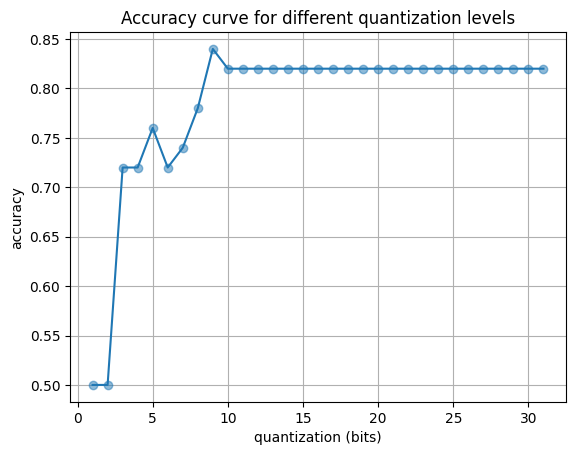

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.array(bits_list)
s = np.array(test_accuracies_list)

fig, ax = plt.subplots()
ax.plot(t, s)
plt.plot(t, s, 'C0o', alpha=0.5)

ax.set(xlabel='quantization (bits)', ylabel='accuracy',
       title='Accuracy curve for different quantization levels')
ax.grid()

fig.savefig("acc_over_bits.png")
plt.show()

In [24]:
bits_quantization = 9

print("Quantizing for {} bits".format(bits_quantization))
# Quantize weights
squeezenet1_1 = create_model()
state_dict = squeezenet1_1.state_dict()
state_dict_quant = quantize_state_dict(state_dict, bits_quantization, bits_quantization)
#print(state_dict_quant)
squeezenet1_1_temp = create_model()
squeezenet1_1_temp.load_state_dict(state_dict_quant)

# Quantize forward activation
squeezenet1_1_quant = quantize_model_forward_activation(squeezenet1_1_temp, bits_quantization)
#print()
#print(squeezenet1_1_quant)

# evaluate
criterion = nn.CrossEntropyLoss()
avg_acc, avg_loss = eval_model(squeezenet1_1_quant, criterion, verbose=True)

Quantizing for 9 bits
Evaluating model
----------
Test batch 10/13
Evaluation completed in 0m 15s
Avg loss (test): 0.1364
Avg acc (test): 0.8200
----------


In [25]:
torch.save(squeezenet1_1_quant.state_dict(), '/content/drive/MyDrive/squeezenet_v4_final_quantized_9.pt')

In [26]:
def dict_to_json(dictionary, json_filename):
    import json

    with open(json_filename, 'w') as fp:
        json.dump(dictionary, fp, indent=4)

# Print model's state_dict
def untensorize_dict(tensor_dict):
    """Converts a dictionary generated directly by pytorch's model.state_dict() method into
    a dictionary with lists instead of tensors"""
    untensored_dict = {}
    for param_tensor in tensor_dict:
        untensored_numpy = tensor_dict[param_tensor].cpu().numpy()
        untensored_dict[param_tensor] = untensored_numpy.tolist() # converts numpy array to nested lists
    return untensored_dict

In [27]:
state_dict_quant_floats_untensored = untensorize_dict(state_dict_quant)
dict_to_json(state_dict_quant_floats_untensored, '/content/drive/MyDrive/squeezenet_v4_final_quantized_9_floats.json')

In [28]:
state_dict_quant_ints = quantize_state_dict(state_dict, bits_quantization, bits_quantization, return_type='int')

state_dict_quant_ints_untensorized = untensorize_dict(state_dict_quant_ints)
dict_to_json(state_dict_quant_ints_untensorized, '/content/drive/MyDrive/squeezenet_v4_final_quantized_9_ints.json')

In [29]:
# check current squeezenet structure to decide where to sample the input and output data
print(squeezenet1_1_quant)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (0_Conv2d_quant): LinearQuant(sf=4, bits=9, overflow_rate=0.000, counter=0)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire_Quant(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_quant): LinearQuant(sf=4, bits=9, overflow_rate=0.000, counter=0)
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_quant): LinearQuant(sf=3, bits=9, overflow_rate=0.000, counter=0)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_quant): LinearQuant(sf=3, bits=9, overflow_rate=0.000, counter=0)
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire_Quant(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1),

In [30]:
layer_outputs = [0]
layer_inputs = [0]

def hook_conv2d_output(module, input, output):
    layer_outputs[0] = output

def hook_conv2d_input(module, input, output):
    layer_inputs[0] = input

data, label = dataloaders['Test_Data'].dataset[0]

if data.dim() == 3:
    # single input sample, force to a 4-dim input
    data = data.unsqueeze(0)

# Set hook to get the input to the conv2d layer
print('Set hook for input capture of "{}"'.format(squeezenet1_1_quant.features[4].squeeze))
squeezenet1_1_quant.features[4].squeeze.register_forward_hook(hook_conv2d_input)

# Set hook to get the output of the quantized layer (after conv2d)
print('Set hook for output capture of "{}"'.format(squeezenet1_1_quant.features[4].squeeze_quant))
squeezenet1_1_quant.features[4].squeeze_quant.register_forward_hook(hook_conv2d_output)


out = squeezenet1_1_quant(data)

# Check if prediction matches the label
_, preds = torch.max(out.data, 1)
print('----')
print('Label is "{}"'.format(label))
print('Prediction is "{}"'.format(preds.item()))

Set hook for input capture of "Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))"
Set hook for output capture of "LinearQuant(sf=4, bits=9, overflow_rate=0.000, counter=0)"
----
Label is "0"
Prediction is "0"


In [34]:
from numpy import array

#print(array(layer_inputs).shape)
#print(array(layer_outputs).shape)

# quantize input
conv2d_input_sf = bits_quantization - 1. - compute_integral_part(layer_inputs[0][0], overflow_rate=args['overflow_rate'])
conv2d_input_quant  = linear_quantize(layer_inputs[0][0], conv2d_input_sf, bits=bits_quantization, return_type='int')
print(conv2d_input_quant)

# quantize output
conv2d_output_sf = bits_quantization - 1. - compute_integral_part(layer_outputs[0], overflow_rate=args['overflow_rate'])
conv2d_output_quant  = linear_quantize(layer_outputs[0], conv2d_output_sf, bits=bits_quantization, return_type='int')
print(conv2d_output_quant)

#print(layer_inputs[0][0])
print(layer_inputs[0][0].size())
print(layer_outputs[0].size())

tensor([[[[20., 20., 20.,  ..., 14., 14., 14.],
          [20., 20., 20.,  ..., 14., 14., 14.],
          [21., 21., 20.,  ..., 13., 13., 13.],
          ...,
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.]],

         [[22., 22., 22.,  ..., 27., 27., 27.],
          [22., 22., 22.,  ..., 27., 27., 27.],
          [22., 22., 22.,  ..., 27., 27., 26.],
          ...,
          [12., 12., 12.,  ..., 12., 12., 12.],
          [12., 12., 12.,  ..., 12., 12., 12.],
          [12., 12., 12.,  ..., 12., 12., 12.]],

         [[ 6.,  6.,  5.,  ..., 16., 16., 16.],
          [ 6.,  6.,  6.,  ..., 16., 16., 16.],
          [ 6.,  6.,  6.,  ..., 17., 17., 17.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

         ...,

         [[ 2.,  2.,  2.,  ...,  2.,  2.,  2.],
          [ 2.,  2.,  